In [1]:
#from ALexNet import AlexNet
#from VGG16 import VGG16

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
#from tqdm import tqdm_notebook
import tqdm.notebook as tq
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torchvision import transforms
from itertools import islice

import albumentations as A
import cv2
from albumentations.pytorch import ToTensor

# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="https://github.com/yandexdataschool/Practical_DL/blob/fall19/week03_convnets/cifar10.jpg?raw=1" style="width:80%">

# Setting up the Notebook

In [2]:
# when running in colab, un-comment this
#!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2021-05-04 23:54:08--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: 'cifar.py'

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2021-05-04 23:54:08 (48.2 MB/s) - 'cifar.py' saved [2396/2396]



## Import Data

In [4]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape, y_train.shape)




Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


## Visualize Data

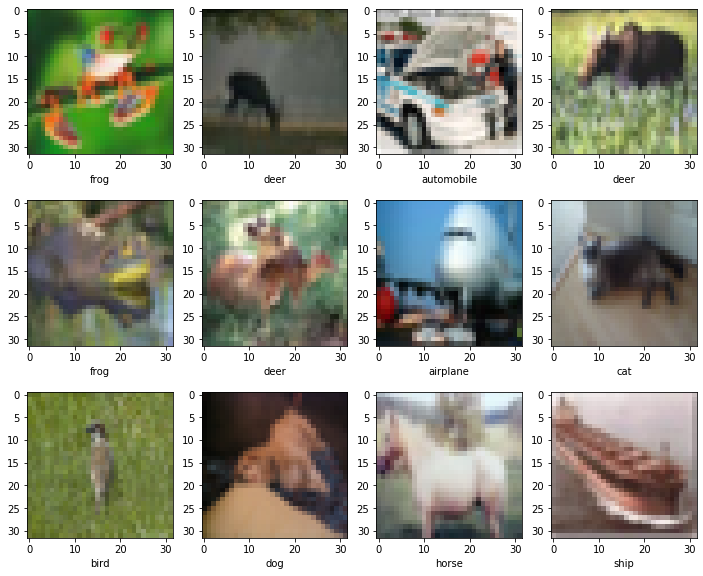

In [5]:
plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

## Create Dataset

In [6]:
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

class Dataset(torch.utils.data.Dataset):
    def __init__(self, imgs, labels, transform=None):
        if transform is None:
            self.transform = A.Compose([
                #A.Normalize(mean=[0.456, 0.406, 0.485],std=[0.224, 0.225, 0.229]),
                #A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                #A.Normalize(mean=means,std=stds),
                ToTensor(),
            ])
            
        else:
            self.transform = transform

        self.labels = labels
        self.imgs = imgs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.imgs)

    def __getitem__(self, index):
        'Generates one sample of data'

        X = self.imgs[index]
        y = self.labels[index]

         
        X = X.transpose([1,2,0])
        
        X = self.transform(image=X)

        return X['image'], y

#training_set = Dataset(X_train, y_train, use_augs=True)
#testing_set = Dataset(X_test, y_test, use_augs=False)

## Create DataLoaders

In [7]:
def get_loaders(training_set, testing_set, batch_size=200):
    trainloader = DataLoader(
        training_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        drop_last=True
    )

    testloader = DataLoader(
        testing_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        drop_last=True
    )
    return trainloader, testloader

## Helper Functions:

### Get Test

In [8]:
def get_acc(test_accuracy):
    if test_accuracy * 100 > 95:
        print("Double-check, than consider applying for NIPS'17. SRSly.")
    elif test_accuracy * 100 > 90:
        print("U'r freakin' amazin'!")
    elif test_accuracy * 100 > 80:
        print("Achievement unlocked: 110lvl Warlock!")
    elif test_accuracy * 100 > 70:
        print("Achievement unlocked: 80lvl Warlock!")
    elif test_accuracy * 100 > 60:
        print("Achievement unlocked: 70lvl Warlock!")
    elif test_accuracy * 100 > 50:
        print("Achievement unlocked: 60lvl Warlock!")
    else:
        print("We need more magic! Follow instructons below")

### Get Convergence Graph:

In [9]:
def convergence_graph(loss_vals):
    print("min loss value", loss_vals[-1])

    plt.plot(range(1, len(loss_vals) +1), loss_vals, color ='blue')
    plt.rcParams["figure.figsize"] = (10,6)
    plt.grid()
    plt.xlabel("Number of iterations")
    plt.ylabel("cost (J)")
    plt.title("Convergence of gradient descent")

### Check Forward Pass

In [10]:
def check_forward_pass(net, trainloader):  
    for batch in islice(trainloader, 0, 1):
        images, labels = batch
        y_pred = net(images)
        print(y_pred.shape)

## Train Model:

In [23]:
device = torch.device(("cuda:0") if torch.cuda.is_available() else "cpu")
num_epochs = 30

def train_model(model, trainloader):
    model.to(device)
    model.train()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss = []

    for epoch in tqdm(range(num_epochs)):
        avg_batch_loss = []
        for batch in trainloader: 
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            
            logits = model(images)
            loss = criterion(logits, labels.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_batch_loss.append(loss.item())
            
        avg = sum(avg_batch_loss) / len(avg_batch_loss)
        train_loss.append(avg)
    return train_loss

## Evaluate Model

In [13]:
def eval_model(model, testloader):
    model.to(device)
    model.train(False) # disable dropout / use averages for batch_norm
    
    test_batch_acc = []
    for batch in testloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        #print(images.shape)
        #print(labels.shape)
        
        #with torch.no_grad():
        y_pred = model(images)
        
        
        y_pred = y_pred.max(1)[1].data.cpu().numpy()
        #print(y_pred)
        #print(labels)
        test_batch_acc.append(np.mean(labels.cpu().numpy() == y_pred))
    test_accuracy = np.mean(test_batch_acc)
    
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(test_accuracy * 100))
    get_acc(test_accuracy)

# Building a network 1

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [14]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [15]:
# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    

model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

# example
print(compute_loss(X_train[:5], y_train[:5]))


tensor(2.3266, grad_fn=<MeanBackward0>)


### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [16]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

indices = np.random.permutation(np.arange(len(X_train)))
len(indices)

40000

In [17]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []
avg_batch_loss = []

In [18]:

num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        #print(X_train)
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())
    avg = sum(train_loss) / len(train_loss)
    avg_batch_loss.append(avg)
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 0.849s
  training loss (in-iteration): 	2.042058
  validation accuracy: 			33.25 %
Epoch 2 of 100 took 0.822s
  training loss (in-iteration): 	1.860235
  validation accuracy: 			36.59 %
Epoch 3 of 100 took 0.829s
  training loss (in-iteration): 	1.788352
  validation accuracy: 			38.77 %
Epoch 4 of 100 took 0.819s
  training loss (in-iteration): 	1.739487
  validation accuracy: 			39.30 %
Epoch 5 of 100 took 0.859s
  training loss (in-iteration): 	1.702355
  validation accuracy: 			40.73 %
Epoch 6 of 100 took 0.837s
  training loss (in-iteration): 	1.670088
  validation accuracy: 			40.18 %
Epoch 7 of 100 took 0.828s
  training loss (in-iteration): 	1.644149
  validation accuracy: 			42.84 %
Epoch 8 of 100 took 0.837s
  training loss (in-iteration): 	1.618323
  validation accuracy: 			42.82 %
Epoch 9 of 100 took 0.843s
  training loss (in-iteration): 	1.598526
  validation accuracy: 			43.97 %
Epoch 10 of 100 took 0.822s
  training loss (in-iteration): 	1.578429
  v

KeyboardInterrupt: 

min loss value 1.7095116532932628


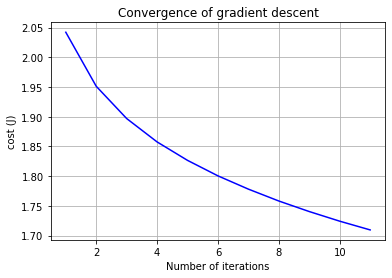

In [19]:
convergence_graph(avg_batch_loss)

In [20]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))


get_acc(test_accuracy)

Final results:
  test accuracy:		44.78 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [21]:
class SmallConvNet(nn.Module):
    def __init__(self):
        super(SmallConvNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.MaxPool2d(2),               # kernel size, stride
        )
        self.fc_model = nn.Sequential(
            nn.Linear(10 * 15 * 15, 100),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(100, 10)
        )
        
        
    def forward(self, X):
        X = self.cnn_model(X)
        X = X.view(X.size(0), -1)  # flatten
        X = self.fc_model(X)  
        return X


  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([200, 10])



100%|██████████| 30/30 [00:34<00:00,  1.15s/it]

min loss value 0.748291345834732


Final results:
  test accuracy:		61.86 %
Achievement unlocked: 70lvl Warlock!


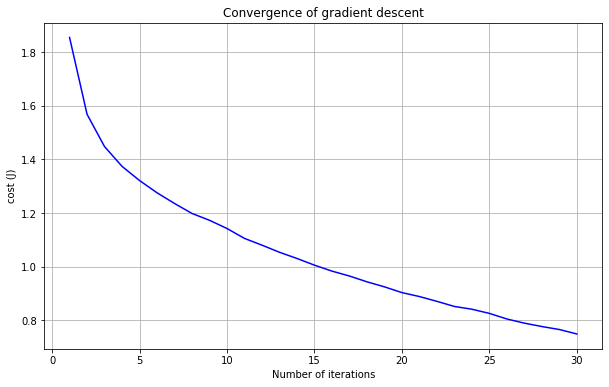

In [24]:
# define model
net = SmallConvNet()

# get training + testing set
training_set = Dataset(X_train, y_train)
testing_set = Dataset(X_test, y_test)

# get loaders
trainloader, testloader = get_loaders(training_set, testing_set)

# check forward pass
check_forward_pass(net, trainloader)

# train model
loss_vals = train_model(net, trainloader)

# get convergence graph
convergence_graph(loss_vals)

# eval model
eval_model(net, testloader)

```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [27]:
class SmallConvBatchNorm(nn.Module):
    def __init__(self):
        super(SmallConvBatchNorm, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3),           # ( in_channels, out_channels, window_size, )
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(2),               # kernel size, stride
        )
        self.fc_model = nn.Sequential(
            nn.Linear(10 * 15 * 15, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(100, 10),
            nn.BatchNorm1d(10),
        )
        
        
    def forward(self, X):
        X = self.cnn_model(X)
        X = X.view(X.size(0), -1)  # flatten
        X = self.fc_model(X)  
        return X

batch_norm_net = SmallConvBatchNorm()


  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([200, 10])



100%|██████████| 30/30 [00:41<00:00,  1.40s/it]

min loss value 0.1714704443886876


Final results:
  test accuracy:		61.04 %
Achievement unlocked: 70lvl Warlock!


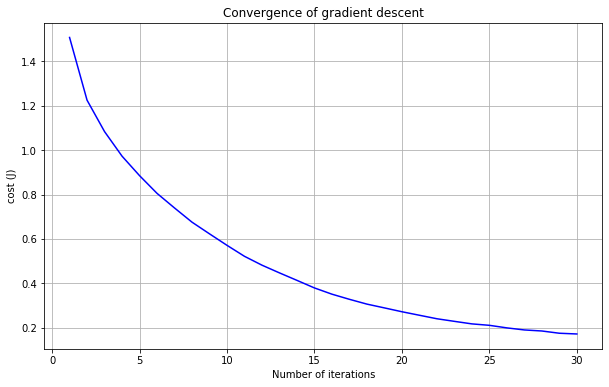

In [29]:
# define model
batch_norm_net = SmallConvBatchNorm()

# get training + testing set
training_set = Dataset(X_train, y_train)
testing_set = Dataset(X_test, y_test)

# get loaders
trainloader, testloader = get_loaders(training_set, testing_set)

# check forward pass
check_forward_pass(batch_norm_net, trainloader)

# train model
loss_vals = train_model(batch_norm_net, trainloader)

# get convergence graph
convergence_graph(loss_vals)

# eval model
eval_model(batch_norm_net, testloader)


```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

### Questions:
     - transforms on PIL image or Tensor?
     - How to determine a healthy batch size?

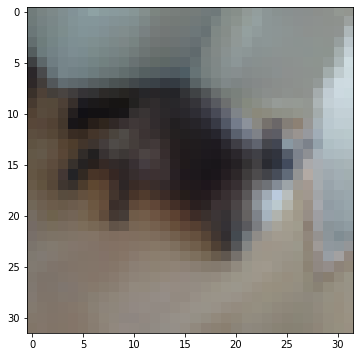

In [36]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.ToTensor(),
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

aug_transform = A.Compose([
    A.Rotate(limit=[-30, 30], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.CenterCrop(width=25, height=25, p=0.3),
    A.Resize(height=32, width=32),
    ToTensor(),
])


pre_img = X_train[7].transpose([1,2,0])
img = aug_transform(image=pre_img)
plt.imshow(img['image'].permute(1, 2, 0))



  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([200, 10])



100%|██████████| 30/30 [00:44<00:00,  1.49s/it]

min loss value 0.9432494559884071


Final results:
  test accuracy:		68.36 %
Achievement unlocked: 70lvl Warlock!


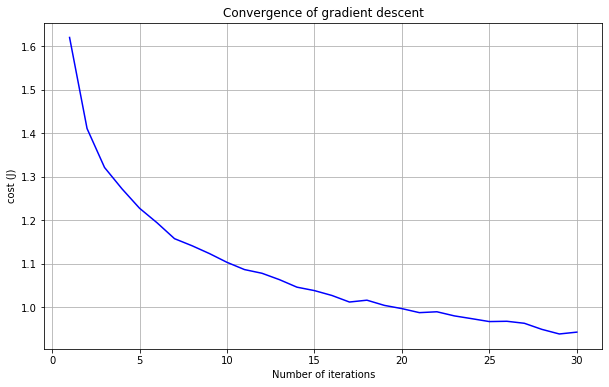

In [37]:
# define model
aug_net = SmallConvBatchNorm()

# get training + testing set
training_set = Dataset(X_train, y_train, transform=aug_transform)
testing_set = Dataset(X_test, y_test)

# get loaders
trainloader, testloader = get_loaders(training_set, testing_set)


# check forward pass
check_forward_pass(aug_net, trainloader)

# train model
loss_vals = train_model(aug_net, trainloader)

# get convergence graph
convergence_graph(loss_vals)

# eval model
eval_model(aug_net, testloader)

In [ ]:
for (x_batch, y_batch) in train_batch_gen:
    
    print('X:', type(x_batch), x_batch.shape);
    print('y:', type(y_batch), y_batch.shape);
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        #print(img.shape)
        plt.subplot(2, 4, i+1);
        plt.imshow(img.transpose([1,2,0]) * stds + means);
        print(img.shape)
        
    
    raise NotImplementedError("Please use this code in your training loop")
    # TODO use this in your training loop

When testing, we don't need random crops, just normalize with same statistics.

# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


## LeNet

In [38]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),            # ( in_channels, out_channels, window_size, )
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),               # kernel size, stride
            nn.Conv2d(6, 16, kernel_size = 5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2), 
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400, 120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(84, 10),
            nn.BatchNorm1d(10),
        )
        

    def forward(self, X):
        X.shape == (batch_size, 3, 227, 227)
        X = self.cnn_model(X)
        X = X.view(X.size(0), -1) 
        X = self.fc_model(X)  
        return X


  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([200, 10])



100%|██████████| 30/30 [00:55<00:00,  1.86s/it]

min loss value 0.9020973491668701


Final results:
  test accuracy:		66.37 %
Achievement unlocked: 70lvl Warlock!


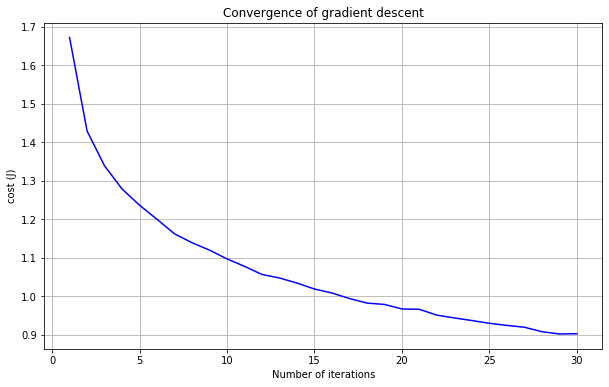

In [39]:
training_set = Dataset(X_train, y_train, transform=aug_transform)
testing_set = Dataset(X_test, y_test)

trainloader, testloader = get_loaders(training_set, testing_set)

leNet = LeNet()

# check forward pass
check_forward_pass(leNet, trainloader)

# # train model
loss_vals = train_model(leNet, trainloader)

# # get convergence graph
convergence_graph(loss_vals)

# eval model
eval_model(leNet, testloader)

## AlexNet

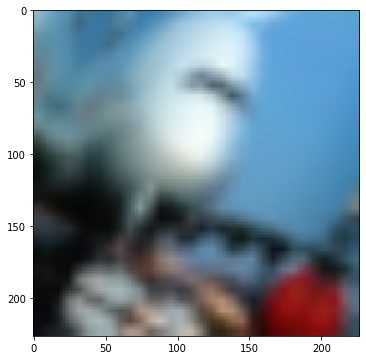

In [40]:
alex_train_transform = A.Compose([
    A.Rotate(limit=[-30, 30], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.CenterCrop(width=25, height=25, p=0.3),
    A.Resize(height=32, width=32),
    A.Resize(height=227, width=227),
    ToTensor(),
    
])

alex_test_transform = A.Compose([
    A.Resize(height=227, width=227),
    ToTensor(),
])

pre_img = X_train[6].transpose([1,2,0])
img = alex_train_transform(image=pre_img)
plt.imshow(img['image'].permute(1, 2, 0))

In [41]:
class AlexNet(nn.Module):
    def __init__(self, pretrained=False, state_dict_path=None):
        super(AlexNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.MaxPool2d(3, stride = 2),                          # kernel size, stride
            nn.Conv2d(96, 256, kernel_size = 5, padding=2, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(3, stride = 2), 
            nn.Conv2d(256, 384, kernel_size = 3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size = 3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size = 3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(3, stride = 2),
        )
        self.fc_model = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10)
        )
        
        self.pretrained = pretrained
        if self.pretrained:
            self.load_state_dict(torch.load(state_dict_path))
        

    def forward(self, X):
        # X.shape == (batch_size, 3, 227, 227)
        X = self.cnn_model(X)
        X = X.view(X.size(0), -1) 
        X = self.fc_model(X)  
        return X




In [ ]:
training_set = Dataset(X_train, y_train, transform=alex_train_transform)
testing_set = Dataset(X_test, y_test, transform=alex_test_transform)

trainloader, testloader = get_loaders(training_set, testing_set)

alexNet = AlexNet()

# check forward pass
check_forward_pass(alexNet, trainloader)

# train model
loss_vals = train_model(alexNet, trainloader)

# get convergence graph
convergence_graph(loss_vals)

# eval model
eval_model(alexNet, testloader)

torch.Size([200, 10])



 93%|█████████▎| 28/30 [15:57<01:08, 34.25s/it]

# VGG16

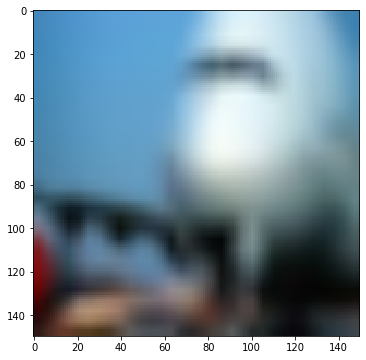

In [33]:
vgg_train_transform = A.Compose([
    A.Rotate(limit=[-30, 30], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.CenterCrop(width=25, height=25, p=0.3),
    A.Resize(height=150, width=150),
    ToTensor(),
    
])

vgg_test_transform = A.Compose([
    A.Resize(height=150, width=150),
    ToTensor(),
])

pre_img = X_train[6].transpose([1,2,0])
img = vgg_train_transform(image=pre_img)
plt.imshow(img['image'].permute(1, 2, 0))

In [44]:
class VGG16(nn.Module):
    def __init__(self, pretrained=False, state_dict_path=None):
        super(VGG16, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2),
            
        )
        self.fc_model = nn.Sequential(
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10)
        )
        
        self.pretrained = pretrained
        if self.pretrained:
            self.load_state_dict(torch.load(state_dict_path))    

    def forward(self, X):
        #X.shape == (batch_size, 512, 7, 7)
        X = self.cnn_model(X)
        X = X.view(X.size(0), -1) 
        X = self.fc_model(X)  
        return X
        

torch.Size([16, 10])




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [02:23<09:33, 143.50s/it]

 40%|████      | 2/5 [04:47<07:10, 143.65s/it]

 60%|██████    | 3/5 [07:11<04:47, 143.77s/it]

 80%|████████  | 4/5 [09:35<02:23, 143.85s/it]

100%|██████████| 5/5 [11:59<00:00, 143.89s/it]

min loss value 2.3027867807388307


Final results:
  test accuracy:		10.00 %
We need more magic! Follow instructons below


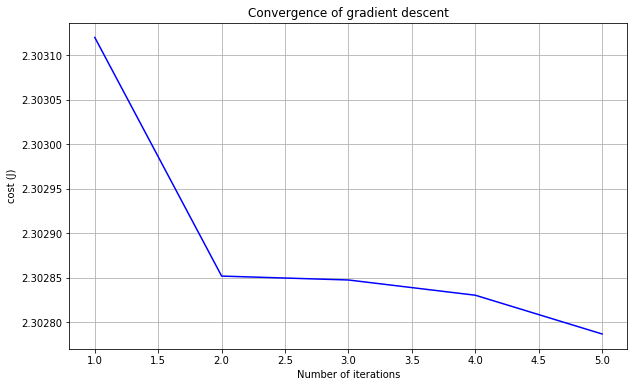

In [57]:
training_set = Dataset(X_train, y_train, transform=vgg_test_transform)
testing_set = Dataset(X_test, y_test, transform=vgg_test_transform)

trainloader, testloader = get_loaders(training_set, testing_set, batch_size=16)

vgg16 = VGG16()

# check forward pass
check_forward_pass(vgg16, trainloader)

# train model
loss_vals = train_model(vgg16, trainloader)

# get convergence graph
convergence_graph(loss_vals)

# eval model
eval_model(vgg16, testloader)

# ResNet

In [56]:
import torch
torch.cuda.empty_cache()

In [3]:
pwd

'/home/iris/paulshab/ShadLab4'